In [41]:
import MDAnalysis as mda
from MDAnalysis.analysis import align,contacts,distances
from MDAnalysis.tests.datafiles import PSF, DCD

import numpy as np
import pandas as pd
np.set_printoptions(precision=2)

import nglview as nv
import warnings
warnings.filterwarnings('ignore')

print( f"MDanalysis: {mda.__version__}" )

MDanalysis: 2.7.0


In [2]:
#nglview settings
def set_view(vlc):
    vlc.background="black"
    vlc.camera='orthographic'
    vlc.player.parameters = dict(delay=0.5, step=1)
    vlc._remote_call('setSize', target='Widget', args=['270px', '270px'])
    vlc.clear_representations()
    vlc.add_representation('surface', selection='not protein', color='blue')
    vlc.add_ribbon(selection='protein',color_scheme="sstruc")
    vlc.center()
    
    return vlc

In [3]:
class Gaussian():
    def __init__(self,Mobile,Reference,sfactor=5.0):
        self.mob , self.ref  = Mobile , Reference
        self.fac , self.sel  = sfactor , 'name CA'
        self.nframes = self.mob.trajectory.n_frames 
        self.natoms  = self.mob.trajectory.n_atoms
                
        # Index of Ca atoms
        self.ndx   = np.where( self.mob.atoms.names == 'CA' )[0]
        self.size  = self.ndx.size
        
        # Get positions
        self.mpos = self.mob.atoms.positions[ self.ndx ]
        self.rpos = self.ref.atoms.positions[ self.ndx ]

        # Output data
        self.result = np.zeros( (self.nframes,2))
        self.coords = np.zeros( (self.nframes,self.natoms,3) , dtype=np.float32 )
        self.weight = np.zeros( (self.nframes,self.size)) 
        
    def g_weights(self):
        #Squared Displacement
        disp = (self.rpos - self.mpos)**2
        dsum = disp.sum(axis=1)
        return np.exp(-(dsum)/self.fac)
        
    def g_fits(self,frame):
        # Forward to specific frame
        self.mob.universe.trajectory[ frame ]
        wRMSD, sRMSD, Conv = 100, 0 , 0 
        # Initial weight 1 for all Ca atoms
        Wgs = np.ones( self.size , dtype=np.float16 )
        
        # Start iterations
        for i in range(50):
            # alignto returns rot.matrix and RMSD
            _,RMSD = align.alignto(self.mob , self.ref , select=self.sel , weights=Wgs, match_atoms=True)
            
            # Updated positions,weights
            self.mpos = self.mob.atoms.positions[ self.ndx ]
            Wgs = self.g_weights() 
            
            if i==0: 
                # First iteration, assign RMSD to std.RMSD
                sRMSD = RMSD
           
            # Check convergence
            if (wRMSD - RMSD) < 0.0001:
                Conv = i+1
                self.coords[frame] = self.mob.atoms.positions
                self.weight[frame] = Wgs
                break
                
            wRMSD = RMSD
        self.result[frame,:] =  sRMSD,wRMSD
        
    def update(self,ts):
        ts.positions = self.coords[ts.frame]
        return ts
        
    def conclude(self,prefix='gfit',output=False):
        columns = ['sRMSD' , 'wRMSD' ]
        self.df = pd.DataFrame(self.result , columns=columns)
        self.wg = pd.DataFrame(self.weight, columns=[ f"R{i}" for i in range(1,self.size+1) ] )
        
        if output:
            self.df.to_csv( f'{prefix}_rms.csv',index_label='Frame')
            self.wg.to_csv( f'{prefix}_wgs.csv',index=False) 
            self.mob.trajectory.add_transformations(self.update)
            sel = self.mob.select_atoms("all")
            with mda.Writer(f'{prefix}_trj.xtc', sel.n_atoms) as W:
                for ts in self.mob.trajectory:
                    W.write(sel)
            print( f"Fitted traj is writtein as {prefix}_trj.xtc")
            
        return self.df        

#### Load trajectory: (MDAnalysis test datafiles)
1. Save first frame as reference structure
2. View the raw trajectory with nglview

In [4]:
# test topology & traj imported in cell one
M = mda.Universe( PSF , DCD ) 
M.atoms.write('ref.pdb')
# Consider first frame as reference frame
R = mda.Universe('ref.pdb')
M.atoms,R.atoms,M.trajectory

(<AtomGroup with 3341 atoms>,
 <AtomGroup with 3341 atoms>,
 <DCDReader /work/apps/MAMBA/envs/MDTOOLS/lib/python3.10/site-packages/MDAnalysisTests/data/adk_dims.dcd with 98 frames of 3341 atoms>)

In [5]:
view = set_view( nv.show_mdanalysis(M) )
view

NGLWidget(background='black', max_frame=97)

#### Gaussian fitted rmsd
- For each frame in the trajectory, produce following outputs
    1. rms.csv
        - sRMSD : Standard RMSD
        - wRMSD : Weighted RMSD
    2. wgs.csv
        - Contain final weights of all $C_\alpha$ atoms
    3. fit.xtc
        - Gaussian fitted output trajectory
- Steps
  - 1. Instantiate the class, passing traj and reference frames
    2. Do gaussian rmsd fit on each frame
    3. Run **conclude()** method to collected outputs
       - **Remember**:
           - Set `output=True` to write output files
           - Set `Prefix` parameter to name output files

In [6]:
%%time
Gauss = Gaussian(M,R)
for frm in M.trajectory:
   Gauss.g_fits(frm.frame)

CPU times: user 834 ms, sys: 0 ns, total: 834 ms
Wall time: 832 ms


In [7]:
# Set prefix and output as true to write output files
data = Gauss.conclude(prefix='adk', output=True)

Fitted traj is writtein as adk_trj.xtc


In [8]:
# View the gauss fitted traj
trj_fit = mda.Universe('ref.pdb','adk_trj.xtc')
view = set_view( nv.show_mdanalysis( trj_fit ) )
view

NGLWidget(background='black', max_frame=97)

In [9]:
# view the data table
data.head(5)

,sRMSD,wRMSD
0,0.000499,0.000499
1,0.423478,0.417808
2,0.593694,0.574287
3,0.736876,0.697940
4,0.827748,0.765723


<Axes: >

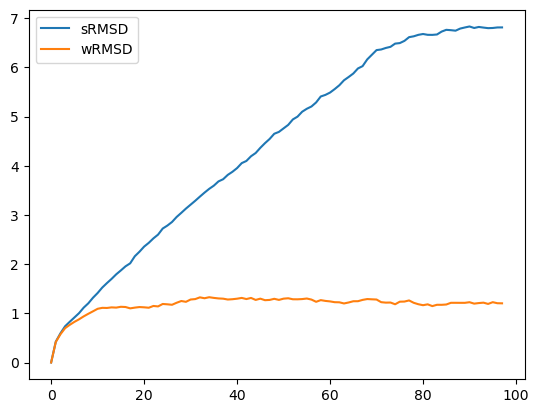

In [10]:
# Plot1: time evolution of rmsd
data.plot()

<Axes: ylabel='Density'>

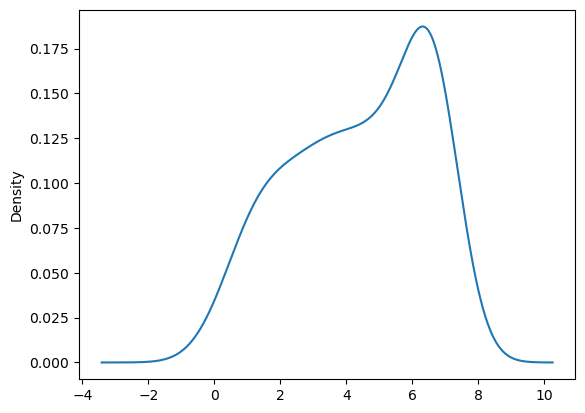

In [11]:
# Plot2: distribution of rmsd
data.sRMSD.plot(kind='kde')

<Axes: xlabel='wRMSD', ylabel='Proportion'>

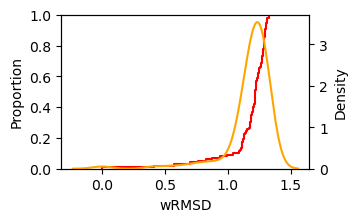

In [12]:
# Plot3: Proportion of weighted RMSD
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots( figsize=(3.2,2) )
tx = ax.twinx()

sns.distplot(data.wRMSD,hist=False , ax = tx , color='orange')
sns.ecdfplot( data.wRMSD ,ax=ax,color='r')

#### Inference
- The plot analysed here shows the transition from the [closed to open](https://www.sciencedirect.com/science/article/abs/pii/S0022283609011164?via%3Dihub) conformation of the enzyme adenylate kinase. 
- The transition results, as expected, in an increase in sRMSD with respect to the initial conformation (Plot 1).
- The increase in sRMSD also results in a broader distribution (Plot 2).
- The wRMSD is smaller than the sRMSD because the alignment ignores the contribution of most mobile regions (plots 1 and 3).
- Proportional plot of wRMSD (Plot 3) shows that nearly 90% of the frames analysed have wRMSD < 1.2 *Ang* (Plot 3).

#### Protein Rigidness
- To quantify the `rigid core` within the protein, we use final weights saved after fitting.
- To this end, we identify $C_{\alpha}$ atoms whose displacement is < 1.2 Ang or whose weights > 0.74
```python
 ( exp( -(1.2**2)/5.0 ) = 0.74
```

In [13]:
# Fraction of atoms with weights higher than 0.74
fn = lambda arr : len( arr[ arr > 0.74 ] )/ arr.size

In [20]:
fweights = pd.read_csv('adk_wgs.csv')
fweights.index.name = 'Frame'
fweights.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R205,R206,R207,R208,R209,R210,R211,R212,R213,R214
Frame,,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.990507,0.983813,0.966405,0.972490,0.984162,0.959239,0.909210,0.877446,0.895497,0.928130,...,0.968560,0.991682,0.978349,0.983641,0.982507,0.948439,0.989742,0.979411,0.900401,0.951308
2,0.992650,0.973005,0.994163,0.946928,0.899749,0.926741,0.951697,0.904009,0.796727,0.874451,...,0.950883,0.956052,0.975435,0.964104,0.971843,0.956540,0.961235,0.951345,0.926405,0.932297
3,0.959887,0.991699,0.966736,0.927229,0.854172,0.978314,0.857724,0.707467,0.729522,0.905576,...,0.946533,0.913566,0.987343,0.989916,0.986632,0.844959,0.784239,0.869382,0.766705,0.730576
4,0.760536,0.964673,0.922877,0.944610,0.869960,0.885127,0.943967,0.709232,0.711489,0.954040,...,0.963897,0.976743,0.962921,0.973843,0.955989,0.836574,0.778331,0.949840,0.729514,0.776696


In [21]:
# For each frame, we obtain the fraction of rigid core
frac = fweights.apply( fn , axis=1)
frac

Frame
0     1.000000
1     1.000000
2     0.981308
3     0.915888
4     0.901869
        ...   
93    0.359813
94    0.341121
95    0.373832
96    0.355140
97    0.341121
Length: 98, dtype: float64

Text(0.5, 1.0, 'Plot-4')

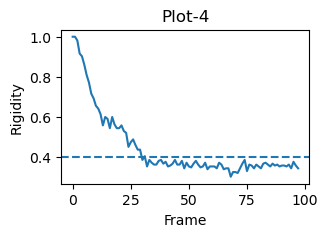

In [22]:
fig,ax = plt.subplots(1,1, figsize=(3.2,2))
sns.lineplot(frac,ax=ax)
ax.set_ylabel('Rigidity')
ax.axhline(0.4,ls='--')
ax.set_title('Plot-4')

In [28]:
# Extract residue numbers of the protein
trj_fit.residues.resids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [29]:
# Here, for each atom, we estimate to what percentage it stays within 1.2 Ang displacement
Byres = fweights.apply( fn )
Byres.index = trj_fit.residues.resids
Byres

1      0.887755
2      0.959184
3      1.000000
4      0.969388
5      0.704082
         ...   
210    0.326531
211    0.306122
212    0.367347
213    0.183673
214    0.122449
Length: 214, dtype: float64

Text(0.5, 1.0, 'Plot-5')

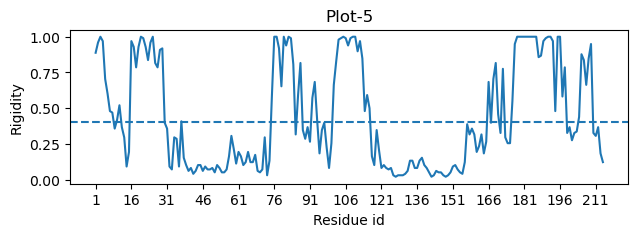

In [30]:
fig,ax = plt.subplots(1,1, figsize=(7.2,2))
sns.lineplot(Byres,ax=ax)
ax.set_ylabel('Rigidity')
ax.axhline(0.4,ls='--')
ax.set_xticks( range(1,215,15))
ax.set_xlabel('Residue id')
ax.set_title('Plot-5')

In [32]:
# Visualize the gaussfit traj, highlight rigid segments in green, whilst mobile as red
view = set_view( nv.show_mdanalysis( trj_fit) )
view.add_cartoon('all',color='green')
# From Plot5, we color two regions of less rigidity
view.add_cartoon('36-70',color='red')
view.add_cartoon('116-163',color='red')
view

NGLWidget(background='black', max_frame=97)

#### **Inferences**

- The reduction in stiffness as a function of simulation time correlates with the conformational transition (plot 4).
- Quantification of the stiffness at the residue level (plot 5) and visual inspection of the gauss-fit trajectory (trj_fit) highlight the most mobile segments (black bands), which show hinge motion at the conformational transition.